<a href="https://colab.research.google.com/github/ychen621/stock-prediction/blob/main/Google_Stock_Forecasting_with_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Stock data was dowloaded from 'https://finance.yahoo.com/quote/GOOG/history?period1=1092922200&period2=1710882285'
# Import the downloaded data as 'df'
df = pd.read_csv('GOOG.csv')

# Select Data and Close columns only
df = df[['Date','Close']]

In [ ]:
# Implementing the function that transforms string to datetime
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [ ]:
# Apply the str_to_datetime fuction to Date column
df['Date'] = df['Date'].apply(str_to_datetime)

# Make Date as the index of the table
df.index = df.pop('Date')

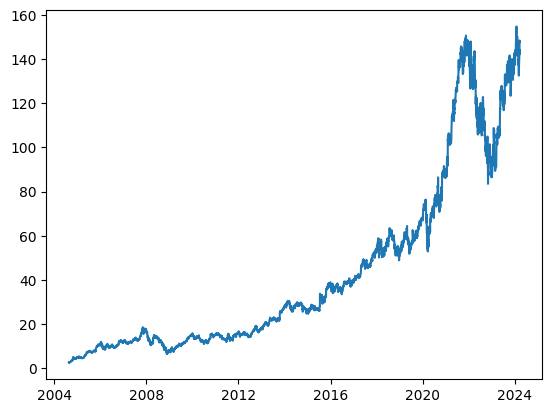

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [ ]:
import numpy as np

"""
Convert the plot to supervised learning problem for LSTM model
Create windows for every target date (target date - 3 days : target date)
 - input: target date-3, target date-2, target date-1
 - output: target
"""

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    # .loc access the rows from the start to target_date
    # .tail select the data of last n+1 results
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Targer Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  #return the numpy array for Tensorflow
  return ret_df

windowed_df = df_to_windowed_df(df,
                                '2023-03-20',
                                '2024-03-18',
                                n=3)

,Targer Date,Target-3,Target-2,Target-1,Target
0,2023-03-20,96.550003,101.070000,102.459999,101.930000
1,2023-03-21,101.070000,102.459999,101.930000,105.839996
2,2023-03-22,102.459999,101.930000,105.839996,104.220001
3,2023-03-23,101.930000,105.839996,104.220001,106.260002
4,2023-03-24,105.839996,104.220001,106.260002,106.059998
...,...,...,...,...,...
246,2024-03-12,135.240005,136.289993,138.940002,139.619995
247,2024-03-13,136.289993,138.940002,139.619995,140.770004
248,2024-03-14,138.940002,139.619995,140.770004,144.339996
249,2024-03-15,139.619995,140.770004,144.339996,142.169998


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middles_matrix = df_as_np[:, 1:-1]
  X = middles_matrix.reshape(len(dates), middles_matrix.shape[1], 1)

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((251,), (251, 3, 1), (251,))

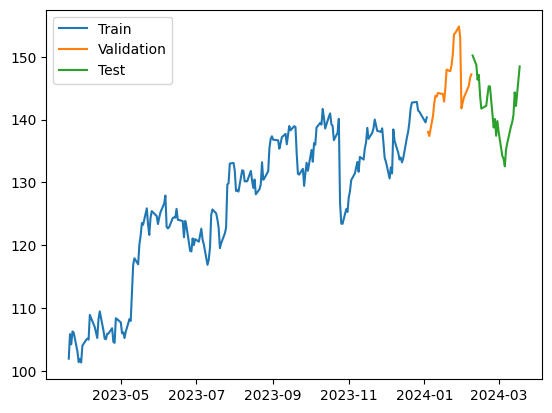

In [ ]:
# Training, Validatin, Testing

q_80 = int(len(dates)*.8)
q_90 = int(len(dates)*.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
# Start training
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 103ms/step - loss: 15964.4502 - mean_absolute_error: 125.8210 - val_loss: 21042.4180 - val_mean_absolute_error: 144.9878
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 15780.5273 - mean_absolute_error: 125.0876 - val_loss: 20821.0508 - val_mean_absolute_error: 144.2224
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 15580.0342 - mean_absolute_error: 124.2858 - val_loss: 20564.0605 - val_mean_absolute_error: 143.3287
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 15335.1748 - mean_absolute_error: 123.2922 - val_loss: 20231.4727 - val_mean_absolute_error: 142.1637
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 15010.2324 - mean_absolute_error: 121.9704 - val_loss: 19772.8770 - val_mean_absolute_error: 140.5415
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 14554.1846 - mean_absolute_error: 120.0814 - val_loss: 19

7/7 [==============================] - 1s 3ms/step


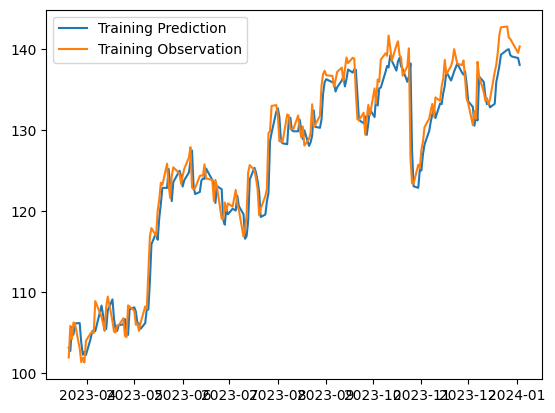

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Prediction', 'Training Observation'])

1/1 [==============================] - 0s 24ms/step


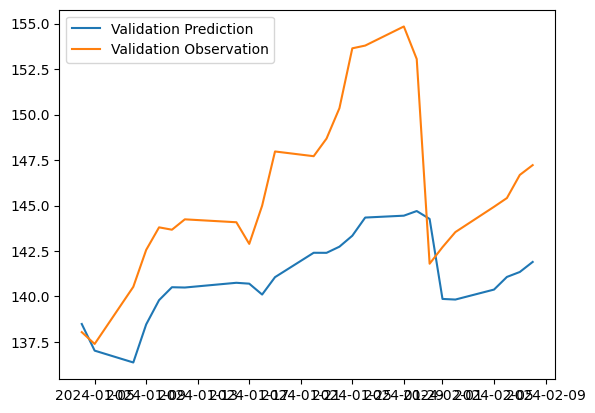

In [ ]:
val_predictions = model.predict(X_val).flatten()


plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Prediction', 'Validation Observation'])

1/1 [==============================] - 0s 26ms/step


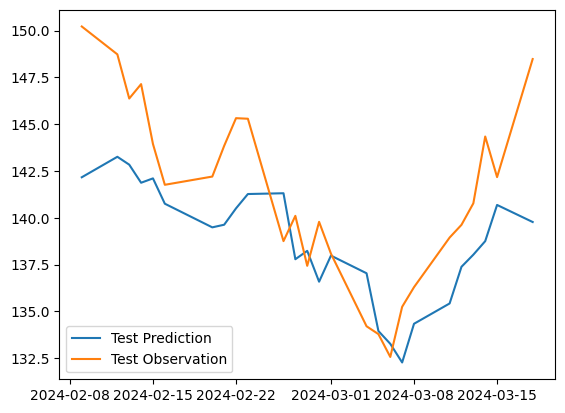

In [ ]:
test_predictions = model.predict(X_test).flatten()


plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Prediction', 'Test Observation'])

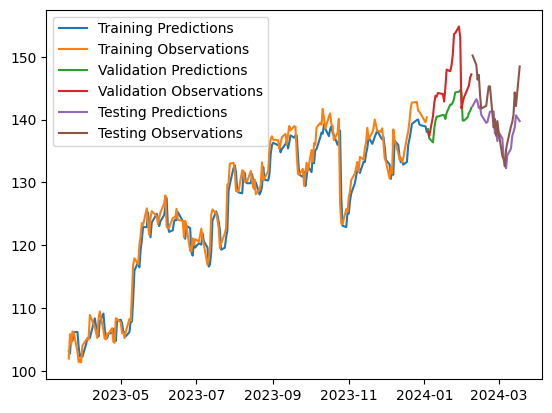

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])